In [1]:
import torch
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from tqdm import tqdm
from PIL import Image, ImageOps

import torch.nn as nn

In [2]:
BATCH_SIZE = 128
EPOCHS = 41

In [3]:
# the training transforms
train_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()
    #transforms.Normalize(std=0.5, mean=0.2)
    
])
# the validation transforms
valid_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()
])

In [4]:
dataset = torchvision.datasets.ImageFolder('F:\my_programs\python\image_recognition\\all_dataset224', transform=train_transform)
print(len(dataset))

338219


In [5]:
classes_dict = dataset.class_to_idx
classes = []
for key in classes_dict.keys():
    classes.append(str(key))
classes.sort()
classes

['(',
 ')',
 '+',
 ',',
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'F',
 'alpha',
 'and',
 'beta',
 'delta',
 'exists',
 'forall',
 'gamma',
 'lambda',
 'mu',
 'not',
 'omega',
 'or',
 'phi',
 'pi',
 'psi',
 'rightarrow',
 'sigma',
 'tau',
 'theta',
 'upsilon',
 'x',
 'y',
 'z']

In [6]:
# classes = ['(', ')', ',', '-', 
#                    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
#                    'A', '[', 'α', 'and', 'β', '∃', 'F', '∀', 
#                    'γ', 'λ', 'μ', 'ω', 'or', 'φ', '→', 
#                    'σ', 'sqrt', 'θ', 'v', 'x', 'y', 'z']

NUM_CLASSES = len(classes)

def map_pred(ind):
    if ind < NUM_CLASSES:
        return classes[ind]
    return 'ERROR MAPPIMG'

NUM_CLASSES

40

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
device

device(type='cuda', index=0)

In [8]:
dataset = torchvision.datasets.ImageFolder('F:\my_programs\python\image_recognition\\all_dataset224', transform=train_transform)
print(len(dataset))

338219


In [9]:
class ResidiumBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout_percentage, is_reducer=True):
        super(ResidiumBlock, self).__init__()
        self.dropout_percentage = dropout_percentage
        self.is_reducer = is_reducer
        if self.is_reducer:
            self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                         kernel_size=3, padding=1, stride=2)
        else:
            self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                         kernel_size=3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.conv2 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                                     kernel_size=3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.act1  = torch.nn.ReLU()
        
        self.conv3 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                                     kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.conv4 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                                     kernel_size=3, padding=1)
        self.bn4 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.act2  = torch.nn.ReLU()
        #self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.dropout = nn.Dropout(p=self.dropout_percentage)

    def forward(self, x):
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if not self.is_reducer:
            x += identity
        x = self.act1(x)
        
        identity = x
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        
        x = self.dropout(x)
        x += identity
        x = self.act2(x)
        
        return x

In [10]:
class MathNet(torch.nn.Module):
    def __init__(self, out_size=NUM_CLASSES):
        super(MathNet, self).__init__()
        self.dropout_percentage = 0.25
        
        # 224x224x1 -> 112x112x64
        self.conv1 =  nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        # 112x112x64 -> 56x56x64
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.block1 = ResidiumBlock(64, 64, self.dropout_percentage, False) # 56x56x64 -> 56x56x64
        self.block2 = ResidiumBlock(64, 128, self.dropout_percentage) # 56x56x64 -> 28x28x128
        self.block3 = ResidiumBlock(128, 256, self.dropout_percentage) # 28x28x128 -> 14x14x256
        self.block4 = ResidiumBlock(256, 512, self.dropout_percentage) # 14x14x256 -> 7x7x512
        # 7x7x512 -> 1x1x512
        self.pool3 = torch.nn.AvgPool2d(kernel_size=7, stride=7, padding=0)
        self.dropout3 = nn.Dropout(p=self.dropout_percentage)
        # 512 -> NUM_CLASSES
        self.fc1 = torch.nn.Linear(512, NUM_CLASSES)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool3(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)  
        return x

In [11]:
def add_contrast(x, factor):
    return transforms.functional.adjust_contrast(x, factor)

In [12]:
mean, std = dataset[0][0].mean(), dataset[0][0].std()
print(mean, std)

tensor(0.7992) tensor(0.3780)


In [13]:
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [14]:
datasets = train_val_dataset(dataset)
print(type(datasets['train']))
print(len(datasets['val']))
# The original dataset is avail


<class 'torch.utils.data.dataset.Subset'>
67644


In [15]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 338219
    Root location: F:\my_programs\python\image_recognition\all_dataset224
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )


67644


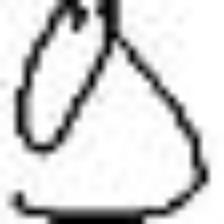

In [16]:
# training dataset
train_dataset = datasets['train']
# validation dataset
valid_dataset = (datasets['val'])
# training data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=6, pin_memory=True
)
# validation data loaders
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=6, pin_memory=True
)
# training data loaders
dataset[0]
print(len(valid_dataset))
#print(valid_dataset.dataset.targets)
aaa = transforms.ToPILImage()
display(aaa(valid_dataset[15451][0]))

In [17]:
from collections import Counter


In [18]:
d = dict(Counter(valid_dataset.dataset.targets))
print(d)

{0: 14293, 1: 14355, 2: 9464, 3: 1906, 4: 15834, 5: 12836, 6: 16968, 7: 11884, 8: 11760, 9: 14853, 10: 12589, 11: 8749, 12: 12158, 13: 12189, 14: 9976, 15: 14407, 16: 7480, 17: 7284, 18: 5634, 19: 5421, 20: 1246, 21: 5896, 22: 16053, 23: 2861, 24: 1105, 25: 1623, 26: 10350, 27: 12527, 28: 5043, 29: 3806, 30: 5775, 31: 1115, 32: 4140, 33: 1525, 34: 608, 35: 6918, 36: 3506, 37: 17559, 38: 9454, 39: 7069}


<AxesSubplot:ylabel='Сharactrs'>

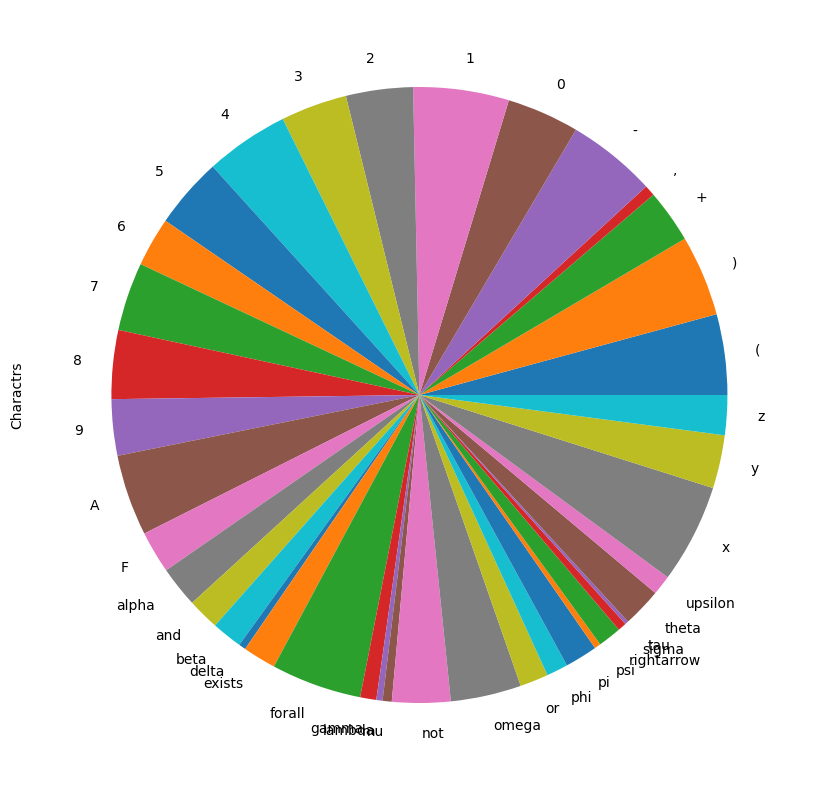

In [19]:
import pandas as pd
df = pd.Series(data=d,name='Сharactrs')    
df.plot(labels=classes,kind='pie',figsize=(10,10))

In [20]:
# training
def train(model, trainloader, optimizer, loss_function):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=int(len(trainloader))):
        counter += 1
        optimizer.zero_grad()
        x, y = data
        x = x.to(device)      
        y = y.to(device)       
        outputs = model.forward(x)
        loss = loss_function(outputs, y)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == y).sum().item()
        loss.backward()
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [21]:
def validate(model, testloader, loss_function):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=int(len(testloader))):
            counter += 1
            x, y = data
            x = x.to(device)      
            y = y.to(device)
            # forward pass
            outputs = model(x)
            # calculate the loss
            loss = loss_function(outputs, y)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == y).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [22]:
model = MathNet()
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
model = model.to(device)
device
type(model)

__main__.MathNet

In [23]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)

In [24]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, label=''):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/mathnet_accuracy'+label+'.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/mathnet_loss'+label+'.png')

In [25]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                              optimizer, loss)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                 loss)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    torch.save(model.state_dict(), 'models/mathnet/mathnet'+str(epoch)+'.ml')
    
# save the trained model weights
torch.save(model.state_dict(), 'models/mathnet/mathnet.ml')
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:10<00:00,  5.70it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.61it/s]


Training loss: 0.217, training acc: 94.705
Validation loss: 0.087, validation acc: 97.491
--------------------------------------------------
[INFO]: Epoch 2 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:45<00:00,  6.11it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.88it/s]


Training loss: 0.082, training acc: 97.696
Validation loss: 0.083, validation acc: 97.589
--------------------------------------------------
[INFO]: Epoch 3 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.14it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.63it/s]


Training loss: 0.067, training acc: 98.047
Validation loss: 0.064, validation acc: 98.063
--------------------------------------------------
[INFO]: Epoch 4 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:45<00:00,  6.12it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:36<00:00, 14.47it/s]


Training loss: 0.058, training acc: 98.261
Validation loss: 0.056, validation acc: 98.347
--------------------------------------------------
[INFO]: Epoch 5 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:01<00:00,  5.86it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:37<00:00, 14.12it/s]


Training loss: 0.052, training acc: 98.427
Validation loss: 0.059, validation acc: 98.273
--------------------------------------------------
[INFO]: Epoch 6 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:01<00:00,  5.85it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:49<00:00, 10.74it/s]


Training loss: 0.046, training acc: 98.569
Validation loss: 0.055, validation acc: 98.318
--------------------------------------------------
[INFO]: Epoch 7 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:45<00:00,  6.11it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.65it/s]


Training loss: 0.042, training acc: 98.684
Validation loss: 0.048, validation acc: 98.536
--------------------------------------------------
[INFO]: Epoch 8 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.14it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.66it/s]


Training loss: 0.038, training acc: 98.818
Validation loss: 0.045, validation acc: 98.621
--------------------------------------------------
[INFO]: Epoch 9 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.62it/s]


Training loss: 0.034, training acc: 98.918
Validation loss: 0.044, validation acc: 98.684
--------------------------------------------------
[INFO]: Epoch 10 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.66it/s]


Training loss: 0.032, training acc: 98.999
Validation loss: 0.040, validation acc: 98.816
--------------------------------------------------
[INFO]: Epoch 11 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.14it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.72it/s]


Training loss: 0.029, training acc: 99.066
Validation loss: 5.410, validation acc: 45.543
--------------------------------------------------
[INFO]: Epoch 12 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.64it/s]


Training loss: 0.027, training acc: 99.112
Validation loss: 0.037, validation acc: 98.922
--------------------------------------------------
[INFO]: Epoch 13 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.13it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:47<00:00, 11.18it/s]


Training loss: 0.025, training acc: 99.201
Validation loss: 0.044, validation acc: 98.681
--------------------------------------------------
[INFO]: Epoch 14 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:58<00:00,  5.90it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:37<00:00, 14.12it/s]


Training loss: 0.023, training acc: 99.238
Validation loss: 0.047, validation acc: 98.640
--------------------------------------------------
[INFO]: Epoch 15 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:38<00:00,  5.30it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:37<00:00, 13.95it/s]


Training loss: 0.022, training acc: 99.291
Validation loss: 0.056, validation acc: 98.383
--------------------------------------------------
[INFO]: Epoch 16 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:05<00:00,  5.78it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.65it/s]


Training loss: 0.020, training acc: 99.342
Validation loss: 2.276, validation acc: 64.000
--------------------------------------------------
[INFO]: Epoch 17 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.13it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.66it/s]


Training loss: 0.018, training acc: 99.406
Validation loss: 0.032, validation acc: 99.132
--------------------------------------------------
[INFO]: Epoch 18 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:45<00:00,  6.11it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.06it/s]


Training loss: 0.017, training acc: 99.434
Validation loss: 0.028, validation acc: 99.221
--------------------------------------------------
[INFO]: Epoch 19 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.14it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.63it/s]


Training loss: 0.015, training acc: 99.479
Validation loss: 0.036, validation acc: 99.082
--------------------------------------------------
[INFO]: Epoch 20 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:50<00:00,  6.03it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.49it/s]


Training loss: 0.014, training acc: 99.521
Validation loss: 0.024, validation acc: 99.366
--------------------------------------------------
[INFO]: Epoch 21 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.16it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.80it/s]


Training loss: 0.013, training acc: 99.541
Validation loss: 0.026, validation acc: 99.326
--------------------------------------------------
[INFO]: Epoch 22 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:48<00:00,  6.06it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:42<00:00, 12.31it/s]


Training loss: 0.013, training acc: 99.584
Validation loss: 0.025, validation acc: 99.324
--------------------------------------------------
[INFO]: Epoch 23 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.13it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:36<00:00, 14.47it/s]


Training loss: 0.012, training acc: 99.588
Validation loss: 0.037, validation acc: 99.046
--------------------------------------------------
[INFO]: Epoch 24 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:27<00:00,  5.46it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:53<00:00,  9.89it/s]


Training loss: 0.011, training acc: 99.644
Validation loss: 0.027, validation acc: 99.296
--------------------------------------------------
[INFO]: Epoch 25 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:17<00:00,  5.59it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.53it/s]


Training loss: 0.011, training acc: 99.632
Validation loss: 0.034, validation acc: 99.080
--------------------------------------------------
[INFO]: Epoch 26 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:46<00:00,  6.09it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.70it/s]


Training loss: 0.009, training acc: 99.681
Validation loss: 0.026, validation acc: 99.352
--------------------------------------------------
[INFO]: Epoch 27 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.13it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.69it/s]


Training loss: 0.009, training acc: 99.675
Validation loss: 0.024, validation acc: 99.419
--------------------------------------------------
[INFO]: Epoch 28 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.49it/s]


Training loss: 0.009, training acc: 99.704
Validation loss: 0.077, validation acc: 98.031
--------------------------------------------------
[INFO]: Epoch 29 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.68it/s]

Training loss: 0.008, training acc: 99.725
Validation loss: 0.030, validation acc: 99.265
--------------------------------------------------
[INFO]: Epoch 30 of 41
Training



100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.49it/s]


Training loss: 0.008, training acc: 99.727
Validation loss: 0.684, validation acc: 86.636
--------------------------------------------------
[INFO]: Epoch 31 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:45<00:00, 11.75it/s]


Training loss: 0.008, training acc: 99.735
Validation loss: 0.026, validation acc: 99.369
--------------------------------------------------
[INFO]: Epoch 32 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.14it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:41<00:00, 12.89it/s]


Training loss: 0.007, training acc: 99.749
Validation loss: 0.030, validation acc: 99.262
--------------------------------------------------
[INFO]: Epoch 33 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:11<00:00,  5.69it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:36<00:00, 14.33it/s]


Training loss: 0.007, training acc: 99.740
Validation loss: 0.024, validation acc: 99.496
--------------------------------------------------
[INFO]: Epoch 34 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:23<00:00,  5.51it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.68it/s]


Training loss: 0.006, training acc: 99.784
Validation loss: 0.552, validation acc: 86.803
--------------------------------------------------
[INFO]: Epoch 35 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:42<00:00,  6.16it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.54it/s]


Training loss: 0.007, training acc: 99.756
Validation loss: 0.045, validation acc: 98.893
--------------------------------------------------
[INFO]: Epoch 36 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.59it/s]


Training loss: 0.006, training acc: 99.799
Validation loss: 0.040, validation acc: 99.017
--------------------------------------------------
[INFO]: Epoch 37 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.14it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:58<00:00,  8.97it/s]


Training loss: 0.006, training acc: 99.761
Validation loss: 0.026, validation acc: 99.428
--------------------------------------------------
[INFO]: Epoch 38 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.13it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.71it/s]


Training loss: 0.006, training acc: 99.806
Validation loss: 0.024, validation acc: 99.494
--------------------------------------------------
[INFO]: Epoch 39 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.14it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.66it/s]


Training loss: 0.006, training acc: 99.805
Validation loss: 0.025, validation acc: 99.491
--------------------------------------------------
[INFO]: Epoch 40 of 41
Training


 29%|██████████████████████▋                                                        | 608/2114 [01:39<04:07,  6.09it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [30]:
[INFO]: Epoch 1 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:10<00:00,  5.70it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.61it/s]

Training loss: 0.217, training acc: 94.705
Validation loss: 0.087, validation acc: 97.491
--------------------------------------------------
[INFO]: Epoch 2 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:45<00:00,  6.11it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.88it/s]

Training loss: 0.082, training acc: 97.696
Validation loss: 0.083, validation acc: 97.589
--------------------------------------------------
[INFO]: Epoch 3 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.14it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.63it/s]

Training loss: 0.067, training acc: 98.047
Validation loss: 0.064, validation acc: 98.063
--------------------------------------------------
[INFO]: Epoch 4 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:45<00:00,  6.12it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:36<00:00, 14.47it/s]

Training loss: 0.058, training acc: 98.261
Validation loss: 0.056, validation acc: 98.347
--------------------------------------------------
[INFO]: Epoch 5 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:01<00:00,  5.86it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:37<00:00, 14.12it/s]

Training loss: 0.052, training acc: 98.427
Validation loss: 0.059, validation acc: 98.273
--------------------------------------------------
[INFO]: Epoch 6 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:01<00:00,  5.85it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:49<00:00, 10.74it/s]

Training loss: 0.046, training acc: 98.569
Validation loss: 0.055, validation acc: 98.318
--------------------------------------------------
[INFO]: Epoch 7 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:45<00:00,  6.11it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.65it/s]

Training loss: 0.042, training acc: 98.684
Validation loss: 0.048, validation acc: 98.536
--------------------------------------------------
[INFO]: Epoch 8 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.14it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.66it/s]

Training loss: 0.038, training acc: 98.818
Validation loss: 0.045, validation acc: 98.621
--------------------------------------------------
[INFO]: Epoch 9 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.62it/s]

Training loss: 0.034, training acc: 98.918
Validation loss: 0.044, validation acc: 98.684
--------------------------------------------------
[INFO]: Epoch 10 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.66it/s]

Training loss: 0.032, training acc: 98.999
Validation loss: 0.040, validation acc: 98.816
--------------------------------------------------
[INFO]: Epoch 11 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.14it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.72it/s]

Training loss: 0.029, training acc: 99.066
Validation loss: 5.410, validation acc: 45.543
--------------------------------------------------
[INFO]: Epoch 12 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.64it/s]

Training loss: 0.027, training acc: 99.112
Validation loss: 0.037, validation acc: 98.922
--------------------------------------------------
[INFO]: Epoch 13 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.13it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:47<00:00, 11.18it/s]

Training loss: 0.025, training acc: 99.201
Validation loss: 0.044, validation acc: 98.681
--------------------------------------------------
[INFO]: Epoch 14 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:58<00:00,  5.90it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:37<00:00, 14.12it/s]

Training loss: 0.023, training acc: 99.238
Validation loss: 0.047, validation acc: 98.640
--------------------------------------------------
[INFO]: Epoch 15 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:38<00:00,  5.30it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:37<00:00, 13.95it/s]

Training loss: 0.022, training acc: 99.291
Validation loss: 0.056, validation acc: 98.383
--------------------------------------------------
[INFO]: Epoch 16 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:05<00:00,  5.78it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.65it/s]

Training loss: 0.020, training acc: 99.342
Validation loss: 2.276, validation acc: 64.000
--------------------------------------------------
[INFO]: Epoch 17 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.13it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.66it/s]

Training loss: 0.018, training acc: 99.406
Validation loss: 0.032, validation acc: 99.132
--------------------------------------------------
[INFO]: Epoch 18 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:45<00:00,  6.11it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.06it/s]

Training loss: 0.017, training acc: 99.434
Validation loss: 0.028, validation acc: 99.221
--------------------------------------------------
[INFO]: Epoch 19 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.14it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.63it/s]

Training loss: 0.015, training acc: 99.479
Validation loss: 0.036, validation acc: 99.082
--------------------------------------------------
[INFO]: Epoch 20 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:50<00:00,  6.03it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.49it/s]

Training loss: 0.014, training acc: 99.521
Validation loss: 0.024, validation acc: 99.366
--------------------------------------------------
[INFO]: Epoch 21 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.16it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.80it/s]

Training loss: 0.013, training acc: 99.541
Validation loss: 0.026, validation acc: 99.326
--------------------------------------------------
[INFO]: Epoch 22 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:48<00:00,  6.06it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:42<00:00, 12.31it/s]

Training loss: 0.013, training acc: 99.584
Validation loss: 0.025, validation acc: 99.324
--------------------------------------------------
[INFO]: Epoch 23 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.13it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:36<00:00, 14.47it/s]

Training loss: 0.012, training acc: 99.588
Validation loss: 0.037, validation acc: 99.046
--------------------------------------------------
[INFO]: Epoch 24 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:27<00:00,  5.46it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:53<00:00,  9.89it/s]

Training loss: 0.011, training acc: 99.644
Validation loss: 0.027, validation acc: 99.296
--------------------------------------------------
[INFO]: Epoch 25 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:17<00:00,  5.59it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.53it/s]

Training loss: 0.011, training acc: 99.632
Validation loss: 0.034, validation acc: 99.080
--------------------------------------------------
[INFO]: Epoch 26 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:46<00:00,  6.09it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.70it/s]

Training loss: 0.009, training acc: 99.681
Validation loss: 0.026, validation acc: 99.352
--------------------------------------------------
[INFO]: Epoch 27 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.13it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.69it/s]

Training loss: 0.009, training acc: 99.675
Validation loss: 0.024, validation acc: 99.419
--------------------------------------------------
[INFO]: Epoch 28 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.49it/s]

Training loss: 0.009, training acc: 99.704
Validation loss: 0.077, validation acc: 98.031
--------------------------------------------------
[INFO]: Epoch 29 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.68it/s]

Training loss: 0.008, training acc: 99.725
Validation loss: 0.030, validation acc: 99.265
--------------------------------------------------
[INFO]: Epoch 30 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.49it/s]

Training loss: 0.008, training acc: 99.727
Validation loss: 0.684, validation acc: 86.636
--------------------------------------------------
[INFO]: Epoch 31 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:45<00:00, 11.75it/s]

Training loss: 0.008, training acc: 99.735
Validation loss: 0.026, validation acc: 99.369
--------------------------------------------------
[INFO]: Epoch 32 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.14it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:41<00:00, 12.89it/s]

Training loss: 0.007, training acc: 99.749
Validation loss: 0.030, validation acc: 99.262
--------------------------------------------------
[INFO]: Epoch 33 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:11<00:00,  5.69it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:36<00:00, 14.33it/s]

Training loss: 0.007, training acc: 99.740
Validation loss: 0.024, validation acc: 99.496
--------------------------------------------------
[INFO]: Epoch 34 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:23<00:00,  5.51it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.68it/s]

Training loss: 0.006, training acc: 99.784
Validation loss: 0.552, validation acc: 86.803
--------------------------------------------------
[INFO]: Epoch 35 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:42<00:00,  6.16it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.54it/s]

Training loss: 0.007, training acc: 99.756
Validation loss: 0.045, validation acc: 98.893
--------------------------------------------------
[INFO]: Epoch 36 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.59it/s]

Training loss: 0.006, training acc: 99.799
Validation loss: 0.040, validation acc: 99.017
--------------------------------------------------
[INFO]: Epoch 37 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.14it/s]

Validation

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:58<00:00,  8.97it/s]

Training loss: 0.006, training acc: 99.761
Validation loss: 0.026, validation acc: 99.428
--------------------------------------------------
[INFO]: Epoch 38 of 41
Training

100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.13it/s]

Validation

 48%|██████████████████████████████████████▋                                         | 256/529 [00:12<00:13, 20.47it/s]

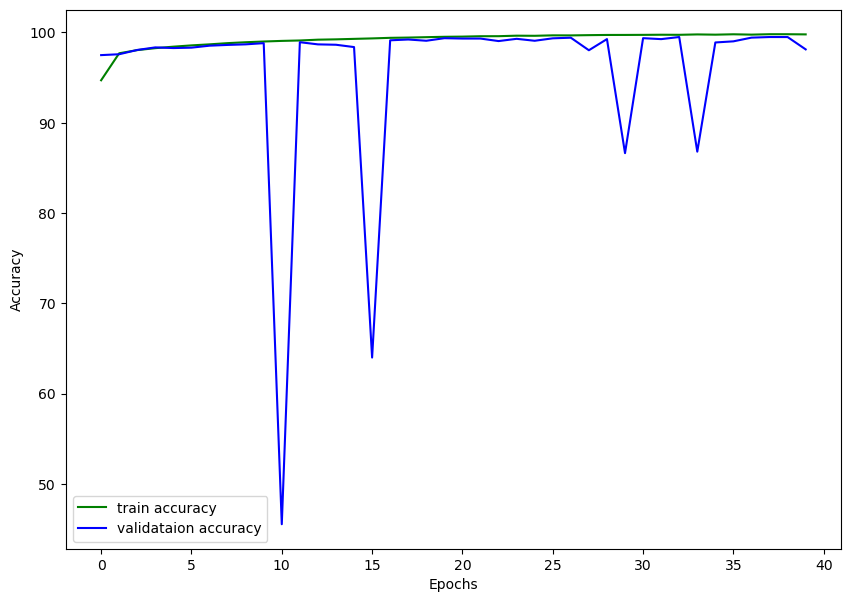

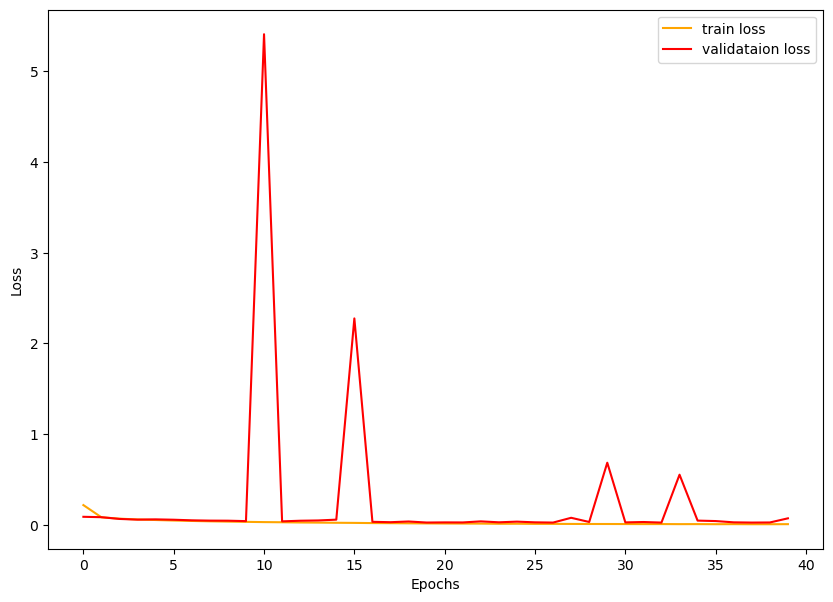

In [32]:
save_plots(train_acc, valid_acc, train_loss, valid_loss)

In [26]:
import cv2
from PIL import Image, ImageOps

img = Image.open("0.jpg")
#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(1),
    transforms.ToTensor()

])        
x_image = convert_tensor(img)

aaa = transforms.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = model(x_image) 
print(pred*10, map_pred(pred.argmax().item()))

torch.save(model.state_dict(), 'models/mathnet/mathnet666.ml')

In [ ]:
import cv2
from PIL import Image, ImageOps

m = MathNet()
m.load_state_dict(torch.load('models/mathnet/mathnet.ml'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
m = m.to(device)
m.eval()

img = Image.open("0.jpg")
#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(1),
    transforms.ToTensor()

])        
x_image = convert_tensor(img)

aaa = transforms.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = m(x_image) 
print(pred*10, map_pred(pred.argmax().item()))